# Running ASFMAUS

In [1]:
using StochasticDiffEq
using DiffEqCallbacks
using DifferentialEquations
 using LinearAlgebra
using Statistics
using SparseArrays

using Plots
using DelimitedFiles

In [2]:
 include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_analysis.jl");

 include("/home/callum/ASF/Modules/ASF_model.jl");

In [23]:
function convert_ode(input, beta, K)
    params = Vector{Any}(undef,15)
    params[1]  = beta
    params[2]  = copy(input.μ_p[1])
    params[3]  = K
    params[4]  = copy(input.ζ[1])
    params[5]  = copy(input.γ[1])
    params[6]  = copy(input.ω[1])
    params[7] = copy(input.ρ[1])
    params[8] = copy(input.λ[1])
    params[9] = copy(input.κ[1])
    params[10] = copy(input.σ[1])
    params[11] = copy(input.bw[1])
    params[12] = copy(input.bo[1])
    params[13] = copy(input.k[1])
    params[14] = copy(input.la[1])
    params[15] = copy(input.lo[1])

    return params
end

convert_ode (generic function with 1 method)

In [260]:
function ASF_ODE!(du,u,p,t)
    β, μ_p, K, ζ, γ, ω, ρ, λ, κ, σ, bw, bo, k, la, lo  = p 
    u[u.<0] .= 0
    S, E, I, R, C = u
    
    N = sum(u)
    
    L = S + E + I + R
    
    ds = μ_p*(σ + ((1-σ))*sqrt(L/K))
    
    du[1] = k*exp(-bw*cos(pi*(t+bo)/365)^2)*(σ .* L .+ ((1-σ)) .* sqrt.(L .* K)) + κ*R - ds*S - β*(I + ω*C)*S/N
    du[2] = β*(I + ω*C)*S/N - (ds + ζ)*E
    du[3] = ζ*E - (ds + γ)*I
    du[4] = γ*(1-ρ)*I - (ds + κ)*R
    du[5] = (ds + γ*ρ)*I -1/( λ + la * cos((t + lo) * 2*pi/365))*C
    
    nothing
end

ASF_ODE! (generic function with 1 method)

In [261]:
input_path = "/home/callum/ASF/Inputs/";
input = ASF_Inputs.Model_Data(input_path);

In [262]:
S0 = 50000
E0 = 0
I0 = 0
R0 = 0
C0 = 0

U0 = [S0,E0,I0,R0,C0]
K = sum(U0)

β  = 0.04

n_years = 5
tspan = (0.0, 365.0)#n_years);

In [263]:
p  = convert_ode(input.Parameters, β, K);

In [264]:
bo = copy(p[12])
p[12] = 0
prob = ODEProblem(ASF_ODE!, U0, tspan, p)
base_pop = solve(prob,Tsit5(), saveat=1);

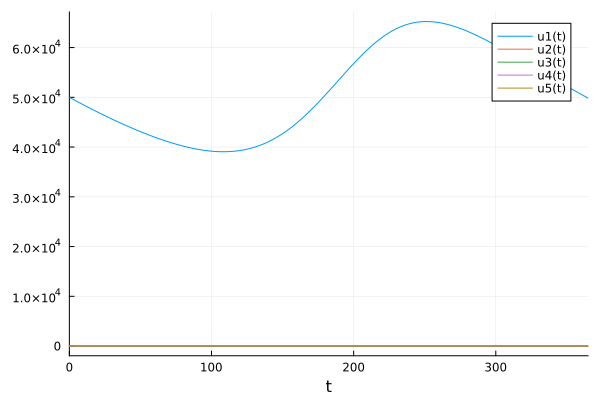

In [265]:
plot(base_pop)

In [266]:
using GpABC, Distances, Distributions, Plots, StatsBase, Printf
using DiffEqCallbacks, DifferentialEquations, LinearAlgebra
using DelimitedFiles, DataFrames, LinearAlgebra, SparseArrays
using QuadGK, Random

In [267]:
bo

0x4b

In [268]:
#running with 5000
#25 infected
#25 exposed



In [269]:
m_t = Normal(180,36.48)
p_d = Normal(85,6.08)
e_p = Normal(2.5,0.608)

Normal{Float64}(μ=2.5, σ=0.608)

In [274]:
aaa = simulator_function_d([0.15327420041677298 0.01751695959104646]);

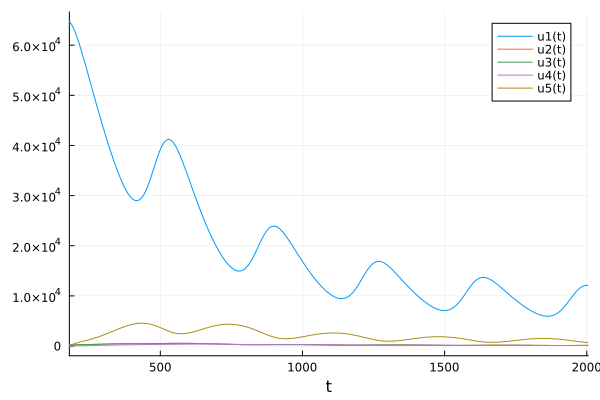

In [275]:
plot(aaa)

In [272]:
aaa

retcode: Success
Interpolation: 1st order linear
t: 1826-element Vector{Float64}:
  180.0
  181.0
  182.0
  183.0
  184.0
  185.0
  186.0
  187.0
  188.0
  189.0
  190.0
  191.0
  192.0
    ⋮
 1994.0
 1995.0
 1996.0
 1997.0
 1998.0
 1999.0
 2000.0
 2001.0
 2002.0
 2003.0
 2004.0
 2005.0
u: 1826-element Vector{Vector{Float64}}:
 [65155.52392274733, 25.0, 25.0, 0.0, 0.0]
 [65128.47803977384, 25.15117673014472, 24.923880394545623, 0.17745477627667158, 3.4229947740171793]
 [65096.131952298725, 25.28128872547087, 24.876719968766515, 0.35283608512835163, 6.725400303885053]
 [65058.59628903042, 25.396567357417016, 24.85221672302076, 0.5263455682254181, 9.914669404133013]
 [65015.98363366272, 25.5016333227589, 24.84564109401906, 0.6981440878351132, 12.997356255259662]
 [64968.40808811779, 25.599908050819632, 24.85343679547962, 0.8683617938859467, 15.979326116489249]
 [64915.984897483875, 25.693920174721487, 24.87292341320999, 1.0371056361579165, 18.865910981247456]
 [64858.83012333813, 25.7855

In [273]:
function AUSF_ODE(dis_params, Tspan, U0)
    
    prob = ODEProblem(ASF_ODE!, U0, Tspan, dis_params)
    sol = solve(prob,Tsit5(), saveat = 1, reltol=1e-8)
    res = eval_out(sol)
    return sol
end
    
function simulator_function_d(var_params)
   start_day = 180
    
    Tspan = (start_day,365*n_years+start_day)
    U0 = copy(base_pop[start_day+bo])

    NE = 250
    NI = 250

    U0[1] -= (NE+NI)
    U0[2] = NE
    U0[3] = NI;

    p  = convert_ode(input.Parameters, 0.1, base_pop[1][1]);
    
    p[1] = var_params[1] #beta
    p[6] = var_params[2] #omega
    
    AUSF_ODE(p, Tspan, U0)
end


function eval_out(sol) 

    output_final = Matrix{Float64}(undef,(3,1))
    
    ep = 0
    mt = 0
    pd = 0
    
    detection_p = 0.05
    pop_K = base_pop[1][1]
    
    starting_p = detection_p*pop_K
    data = reduce(vcat,transpose.(sol.u))
   
    s = data[:,1]
    e = data[:,2]
    i = data[:,3]
    r = data[:,4]
    c = data[:,5]
    
    ds = e .+ i
    dt = e .+ i .+ c
    
    f = s .+ r 
    p = e .+ i .+ s .+ r 

    if dt[end] > 5
            
        ep = 100*mean(ds[3*365:end])/mean(p[3*365:end])
        
        pd = 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(dt)[2][1]

        if maximum(dt) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), dt)[1]
        end

        mt = max_d-take_off_time
    
        output_final[1] = pdf.(e_p,ep)/pdf.(e_p,mean(e_p))
        output_final[2] = pdf.(p_d,pd)/pdf.(p_d,mean(p_d))
        output_final[3] = pdf.(m_t,mt)/pdf.(m_t,mean(m_t))
          
    else
        output_final[1] = 0
        output_final[2] = 0
        output_final[3] = 0
        
    end
   
    return output_final
    
end

function observed_params()
   
    obs =  Matrix{Float64}(undef,(3,1))
    
    obs[1] = 1 #2.5 #endemic prev
    obs[2] = 1#80 #population delcine %
    obs[3] = 1#8 month #time (days) from init to max
    
    return obs
end

observed_params (generic function with 1 method)

In [238]:
aa = quantile.(m_t, [0.8])[1]
bb = pdf.(m_t,aa)/pdf.(m_t,mean(m_t))
sqrt(3*(1-bb)^2)

0.5165660265550855

In [239]:
#0.95,0.85,0.8,0.75
thresh_shed = [1.2841903149896468,0.7197669138598748,0.5165660265550855, 0.35225226223770106]

4-element Vector{Float64}:
 1.2841903149896468
 0.7197669138598748
 0.5165660265550855
 0.35225226223770106

In [240]:
n_years = 10 #how many years each sim will run for
obs = observed_params() #our observed (just array of ones, we normalise output to be relative to this)
priors = [Uniform(0.001, 0.5), Uniform(0.001, 0.5)];

In [241]:
n_particles = 250;

In [242]:
sim_abcsmc_res = SimulatedABCSMC(obs,simulator_function_d,priors,thresh_shed,n_particles; write_progress=true)

┌ Info: GpABC rejection simulation. ϵ = 1.2841903149896468.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 16/1000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 31/2000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:87
┌ Warning: Simulation reached maximum iterations 2500 before finding 250 particles - will return 38
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:92
┌ Info: GpABC SMC simulation ϵ = 0.7197669138598748
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 3/1000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 5/2000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Warning: Simulation reached maximum 

GpABC.SimulatedABCSMCOutput(2, [38, 7, 232, 77], [2500, 2500, 2500, 2500], [1.2841903149896468, 0.7197669138598748, 0.5165660265550855, 0.35225226223770106], AbstractMatrix{Float64}[[0.096292545419228 0.10798267206135455; 0.15782336345420842 0.02711892305657978; … ; 0.1380578999618776 0.04723163928393295; 0.05510588737412131 0.2923729672184221], [0.16117829282217913 0.010796350812738331; 0.16033717459914051 0.012110990591138654; … ; 0.16253275270299625 0.008181848011773712; 0.14660527985560448 0.028203573214849675], [0.1676554921610603 0.006374284702296024; 0.15043657240864416 0.022494943392162008; … ; 0.15995954525301603 0.0113816936398669; 0.1466518854220348 0.023977227715374964], [0.15342012338488942 0.01756223726711147; 0.15278778975106927 0.01705105271353498; … ; 0.15078408332747675 0.01967267323255906; 0.14932782844427428 0.02103275165692331]], AbstractVector{Float64}[[1.0784955781204633, 1.122020731114858, 1.1657643204552235, 0.4308201571230128, 1.1237444992697805, 1.11522244718

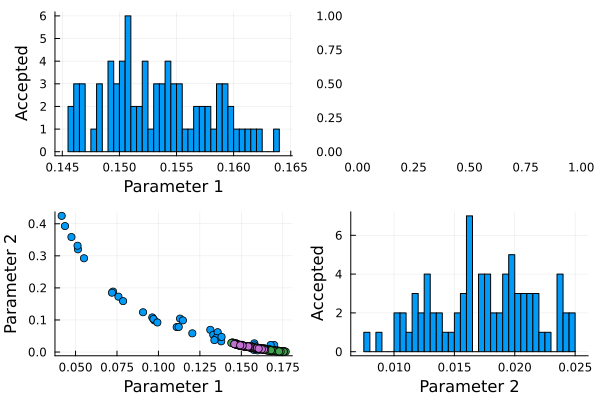

In [243]:
plot(sim_abcsmc_res)

In [252]:
median(sim_abcsmc_res.population[4][:,1])

0.15327420041677298

In [254]:
median(sim_abcsmc_res.population[4][:,2])

0.01751695959104646

In [ ]:
data = reduce(vcat,transpose.(sol.u))
    
if any(x->x <0, data)
    println("Need to Reduce Timestep")
    data[data .< 0 ] .= 0
end

s_d = data[:,1:5:end]
e_d = data[:,2:5:end]
i_d = data[:,3:5:end]
r_d = data[:,4:5:end]
c_d = data[:,5:5:end]

disease = e_d + i_d + c_d #classes with disease
disease_free = s_d + r_d #classes without disease

disease_sum = sum(disease,dims=2);
pop_sum = sum(disease_free,dims=2);

In [ ]:
plot(pop_sum)
plot!(disease_sum)

In [ ]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model
prob = ODEProblem(SEIRC_ODE!,input_1.U0,(0.0,365.0*N_years),input_1.Parameters);
sol=solve(prob, QNDF(),saveat=1);


In [68]:
function sensitivity3(n_networks, n_runs, path,name)
    
   
    input_folder = splitpath(path)[end]
    base_path = rsplit(path, input_folder)[1]
    
    #making save directory
    dir = "$(base_path)Results/$(name)"

    isdir(dir) || mkdir(dir)
    cd(dir)

    #copying inputs
    cp("$(path)", "Inputs",force = true)

    for i = 1:n_networks

        println("$(100*i/n_networks) %")
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model

        rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
        prob = DiscreteProblem(init_pop,inputs.Time,inputs.Parameters)
        jump_prob = JumpProblem(prob,Direct(),rj) 
        ensemble_prob_m = EnsembleProblem(jump_prob)


        outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,dt=1)
        stats = one_population_analysis(outputs) #stats for each run
        writedlm( "Results_$(i).csv",  stats, ',')
    end
        

end

sensitivity3 (generic function with 1 method)

In [69]:
function one_population_analysis(output)
    
    stats = 6
    years_till_endemic = 3
    classes, t_steps, n_ens = size(output) 
    times = output[1].t
    n_g = classes ./ 5

    Data_store = Matrix{Float32}(undef,n_ens,stats)

    for i in 1:n_ens #looping through ensemble_run

        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))

        if any(x->x <0, data)
            println("Need to Reduce Timestep")
            data[data .< 0 ] .= 0
        end
        
        s_d = data[:,1:5:end]
        e_d = data[:,2:5:end]
        i_d = data[:,3:5:end]
        r_d = data[:,4:5:end]
        c_d = data[:,5:5:end]

        disease_total = e_d + i_d + c_d #classes with disease
        disease_alive = e_d + i_d

        disease_free = s_d + r_d #classes without disease
        
        disease_sum = sum(disease_total,dims=2)
        diease_alive_sum =  sum(disease_alive,dims=2)
        disease_free_sum = sum(disease_free,dims=2)
        population_sum = diease_alive_sum + disease_free_sum
        
        #we first want to see dieout time/if the diease was endemic 
        if disease_sum[end] > 0
            #Endemic/still present at end of simulation
            Data_store[i,1] = -1
        else #dies out
            dieout_index = findfirst(==(0), disease_sum)[1]
            Data_store[i,1] = times[dieout_index]
        end

        #now lets find the maximum time
        max_time_index=findfirst(==(maximum(disease_sum)), disease_sum)[1]
        Data_store[i,2] = times[max_time_index]

        #Endemic prevalence and groups alive
        if Data_store[i,1] == -1 #if endemic
            prevalence = 100*(diease_alive_sum ./ population_sum)
            e_prev = prevalence[365*years_till_endemic:end]
            Data_store[i,3] = mean(e_prev)
        else
            Data_store[i,3] = 0
        end

        #now looking at the number of groups alive at either dieout time or end if endemic
        exposed_groups = sum(disease_total, dims = 1)
        n_exposed = count(>(0), exposed_groups)
        Data_store[i,4] = 100*n_exposed/n_g
        
        population_decline = 100(1-minimum(population_sum)/population_sum[1])
        Data_store[i,5] = population_decline
        
        
        #Now want to look at minimum number of groups alive

        mimum_alive = minimum(sum((disease_alive + disease_free) .> 0, dims = 2))
        Data_store[i,6] = 100*mimum_alive/n_g
    end
    
    return Data_store

end


one_population_analysis (generic function with 1 method)

## Running Multiple Networks

In [71]:
sensitivity3(10,10,input_path,"ONE_5")

10.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
20.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
30.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
40.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
50.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
60.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
70.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
80.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
90.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!
100.0 %
Watts Strogatz Small Worlds Network
Random: 1
Warning 1 disconnected feral groups!


In [ ]:
Threads.nthreads()

In [ ]:
function sensitivity(n_networks, n_dist, n_runs, path, name)
    
    input_folder = splitpath(path)[end]
    base_path = rsplit(path, input_folder)[1]

    #making save directory
    dir = "$(base_path)Results/$(name)"

    isdir(dir) || mkdir(dir)
    cd(dir)

    #copying inputs
    cp("$(path)", "Inputs",force = true)
    
    for i = 1:n_networks
        println("$(100*i/n_networks) %")
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model
        for j = 1:n_dist

            rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
            prob = DiscreteProblem(inputs.U0,inputs.Time,inputs.Parameters)
            jump_prob = JumpProblem(prob,Direct(),rj) 
            ensemble_prob_m = EnsembleProblem(jump_prob)
            outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

            summary = ASF_Analysis.quick_analysis(outputs, inputs) #update to new function from module (ASF_Model.quick_analysis(outputs))

            writedlm( "Results_$(i)_$(j).csv",  summary, ',')
            ASF_Model.reparam!(inputs) #re-doing params with
        end
        

    end
    re
end

In [ ]:
function sensitivity2(n_networks, n_dist, n_runs, path)
    sumss = Vector{Float64}(undef, n_networks*n_dist*n_runs)
    println(n_runs)
    println(n_dist)
    println(n_networks)
    for i = 1:n_networks
        println("$(100*i/n_networks) %")
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model

        inputs.U0[1:5:end] += (inputs.U0[2:5:end] +inputs.U0[3:5:end])
        inputs.U0[2:5:end] .= 0;
        inputs.U0[3:5:end] .= 0;

        for j = 1:n_dist

            rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
            prob = DiscreteProblem(inputs.U0,inputs.Time,inputs.Parameters)
            jump_prob = JumpProblem(prob,Direct(),rj) 
            ensemble_prob_m = EnsembleProblem(jump_prob)
            outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

            #summary = ASF_Analysis.quick_analysis(outputs, inputs) #update to new function from module (ASF_Model.quick_analysis(outputs))

            for k = 1:n_runs
                final_p = sum(outputs[k].u[end])/sum(inputs.U0)
                sumss[n_networks*(i-1)+k] = final_p
            end
            ASF_Model.reparam!(inputs) #re-doing params with
        end
        

    end
    return sumss
end

In [ ]:
sensitivity(10,10,10,Linear, "ET") # running 

## Analysing Output

In [ ]:
density = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Baseline//");
connect_5 = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Connect_5//");


In [ ]:
density_r = ASF_Analysis.three_statistics(density,20, p_out = true);

In [ ]:
connect_5_r = ASF_Analysis.three_statistics(connect_5,20, p_out = true);

In [ ]:
using DifferentialEquations, BenchmarkTools

In [ ]:
function lorenz(u,p,t)
    dx = 10.0*(u[2]-u[1])
    dy = u[1]*(28.0-u[3]) - u[2]
    dz = u[1]*u[2] - (8/3)*u[3]
    [dx,dy,dz]
   end

In [ ]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
@benchmark solve(prob,Tsit5())

In [ ]:
u0 = [1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(lorenz,u0,tspan)
@benchmark solve(prob,Tsit5(),save_everystep=false)

In [ ]:
function SEIRC_ODE!(du,u,p,t)
    
    ref_density = 3
    
    u[u.<0].=0 
    
    S = u[1:5:end]
    E = u[2:5:end]
    I = u[3:5:end]
    R = u[4:5:end]
    C = u[5:5:end]
  
    N = S + E + I + R + C .+ 0.0001
    Np = S + E + I + R
    
    Pops = p.Populations 
    
    tp = Pops.cum_sum[end]

    beta = copy(p.β)
    
   
    #calculating density of region
    #for i in 1:Pops.pop
    #    nf = Pops.feral[i] #number of feral groups in region
    #    ncs = Pops.cum_sum[i] #cumsum of farm and ferals over all regions
    N_feral = sum(Np) #total feral population in region i
    Density = N_feral/Pops.area[1]
    beta = beta * Density/ref_density
   #end

    column(i) = N .+ N[i]
    populations  = hcat([column(i) for i=1:tp]...)
    populations[diagind(populations)] = N;

    connected_pops = p.β_b * Np

    #procceses 
    Births = p.μ_b .* Np
    Births[(p.μ_c .== 1) .& (Np .> 0)] .= 0 #preventing boar populations growing larger than one!
    Births[(Np .== 0) .& (connected_pops .>2)] .= mean(p.μ_b)*2 #allowing migration births if neighbouring groups have pop
    

    
    du[1:5:end] = Births - ((beta.* S) ./ populations) * (I + p.ω .* C) - p.μ_d .* S + (p.μ_b-p.μ_d)./tanh(1).*S.*tanh.(Np./p.μ_c)  + p.κ .* R #S
    du[2:5:end] = ((beta.* S) ./ populations) * (I + p.ω .* C) - p.ζ .* E - p.μ_d .* E + (p.μ_b-p.μ_d)./tanh(1).*E.*tanh.(Np./p.μ_c) #E
    du[3:5:end] = p.ζ .* E - p.γ .* I -  p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) #I
    du[4:5:end] = p.γ .* (1 .- p.ρ) .* I - p.μ_d .* R + (p.μ_b-p.μ_d)./tanh(1).*R.*tanh.(Np./p.μ_c) - p.κ .* R  #R
    du[5:5:end] = p.ρ .* p.γ .* I + p.μ_d .* I+ (p.μ_b-p.μ_d)./tanh(1).*I.*tanh.(Np./p.μ_c) - p.λ .* C#C
    nothing
end

In [ ]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model
prob = ODEProblem(SEIRC_ODE!,input_1.U0,(0.0,10*365.0),input_1.Parameters);



In [ ]:
sol=solve(prob, AutoTsit5(Rosenbrock23()),saveat=7);

In [ ]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),saveat=7)


In [ ]:
@benchmark solve(prob, AutoTsit5(Rosenbrock23()),saveat=1)


In [ ]:
@benchmark solve(prob, Tsit5(),saveat=1)


In [ ]:
p = [β, β_b,β_d,μ_b,μ_d,μ_c,ζ,γ,ω,ρ,λ,κ, pops]; 



In [ ]:
β = input_1.Parameters.β
β_b = input_1.Parameters.β_b
β_d= input_1.Parameters.β_d
μ_b= input_1.Parameters.μ_b
μ_d= input_1.Parameters.μ_d
μ_c= input_1.Parameters.μ_c
ζ= input_1.Parameters.ζ
γ= input_1.Parameters.γ
ω= input_1.Parameters.ω
ρ= input_1.Parameters.ρ
λ= input_1.Parameters.λ
κ= input_1.Parameters.κ
pops= input_1.Parameters.Populations


In [ ]:
input_1.Parameters.Pops